# Introduction

The Titanic competition's goal is quite simple: we have a training data which has different informations about the passengers at board in the famous Titanic ship, and we have to predict whether new passengers (unseen by our ML model) will survive or not.

# Understanding the data
Survival : 0 = No, 1 = Yes

Pclass : Passenger's social economic class 1st = Upper 2nd = Middle 3rd = Lower

SibSp : The number of siblings and spouses

Parch : The number of parents

Ticket : Ticket number

Fare : Passenger fare

Cabin : Cabin number embarked

Embarked: Where the passenger embarked. C = Cherbourg, Q = Queenstown, S = Southampton

Name, Sex , Age are self-explanatory

### Dependencies

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Reading Data

In [2]:
train_data = pd.read_csv('Data/train.csv', index_col='PassengerId')
test_data = pd.read_csv('Data/test.csv', index_col='PassengerId')
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### How Should Performance be Measured?

In [3]:
train_data.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

There is a significant amount of positive class values. Let's use as performance measure the ROC AUC score.

# Exploratory Data Analysis (EDA)

In [4]:
df = train_data.copy()

In [5]:
cols = list(df.columns)
cols

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
def null_count(df):
    null_count = df.isnull().sum()
    null_count = null_count[null_count > 0] / len(df) * 100
    null_count.sort_values(inplace=True)
    return null_count

null_count(df)

Embarked     0.224467
Age         19.865320
Cabin       77.104377
dtype: float64

In [8]:
cols.remove("Cabin")

In [9]:
num_cols = list(df.select_dtypes(exclude=["object"]).columns)
obj_cols = list(df.select_dtypes(include=["object"]).columns)
obj_cols.remove("Cabin")
num_cols.remove("Survived")

### Numerical Columns

In [10]:
df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Age     714 non-null    float64
 2   SibSp   891 non-null    int64  
 3   Parch   891 non-null    int64  
 4   Fare    891 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 41.8 KB


In [11]:
def plot_distributions(df, graph_type, cols=list(df.columns), n_cols=5):
    """[summary]

    Args:
        df ([type]): [description]
        graph_type ([type]): [description]
        cols ([type], optional): [description]. Defaults to list(df.columns).
        n_cols (int, optional): [description]. Defaults to 5.

    Returns:
        [type]: [description]
    """
    
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig = make_subplots(n_rows, n_cols, subplot_titles=cols)
    
    i = 1
    j = 1
    for i in range(1, n_rows + 1):
        for j in range(1, n_cols + 1):
            col = cols[(i - 1) * n_cols + j - 1]
            if graph_type == 'hist':
                fig.add_trace(go.Histogram(x=df[col], name=col), row=i, col=j)
            elif graph_type == 'box':
                fig.add_trace(go.Box(y=df[col], name=""), row=i, col=j)
            elif graph_type == 'violin':
                fig.add_trace(go.Violin(y=df[col], name=""), row=i, col=j)
                    
    fig.update_layout(height=400, width=1000, title_text=graph_type.capitalize() + " plots of " + str(len(cols)) + " columns")
    return fig
    

fig = plot_distributions(df, "box", num_cols, 5)
fig.show()

In [12]:
fig = plot_distributions(df, "hist", num_cols)
fig.show()

In [13]:
fig = make_subplots(rows=1, cols=5, subplot_titles=num_cols)

for idx, col in enumerate(num_cols):
    if col in ["Age", "Fare"]:
        grouped_df = df[[col, "Survived"]].groupby(col).mean()
        fig.add_trace(go.Scatter(x=grouped_df.index, y=grouped_df.Survived, name=col, mode="markers"), row=1, col=idx + 1)
    else:
        grouped_df = df[[col, "Survived"]].groupby(col).mean()
        fig.add_trace(go.Bar(x=grouped_df.index, y=grouped_df.Survived, name=col), row=1, col=idx + 1)
    
fig.update_layout(height=400, width=1000, title_text="Bar plots of " + str(len(num_cols)) + " columns")    

fig.show()

In [14]:
fig = px.histogram(df, x="Age", facet_col="Survived", nbins=20,
                   color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Age")
fig.show()

In [15]:
df["Age_class"] = train_data["Age"] // 15 * 15

In [16]:
fig = px.histogram(df, x="Age_class", facet_col="Survived", nbins=20,
                   color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Age")
fig.show()

In [17]:
fig = px.histogram(df, x="Fare", facet_col="Survived", color="Survived", nbins=20,
                   color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Fare")
fig.show()

In [18]:
fig = px.box(df, y="Fare", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Fare")
fig.show()

In [19]:
fig = px.histogram(df, x="Pclass", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Pclass")
fig.show()

In [20]:
fig = px.histogram(df, x="SibSp", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Nº of Siblings/Spouses")
fig.show()

In [21]:
fig = px.histogram(df, x="Parch", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Nº of Parents/Children")
fig.show()

### Object Columns

In [22]:
df[obj_cols].head()

,Name,Sex,Ticket,Embarked
PassengerId,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
5,"Allen, Mr. William Henry",male,373450,S


In [23]:
df[obj_cols].describe()

,Name,Sex,Ticket,Embarked
count,891,891,891,889
unique,891,2,681,3
top,"Marechal, Mr. Pierre",male,1601,S
freq,1,577,7,644


In [24]:
cols.remove("Ticket") # too many unique values

In [25]:
fig = px.histogram(df, x="Sex", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Sex")
fig.show()

In [26]:
fig = px.histogram(df, x="Embarked", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Embarked")
fig.show()

In [27]:
def get_title(name):
    name = name.split(" ")
    title = name[1]
    if title in ["Mr.", "Mrs.", "Miss.", "Master."]:
        return title
    else:
        return "Other"

In [28]:
df["title"] = df.Name.map(get_title)
df.title.value_counts()

Mr.        502
Miss.      179
Mrs.       121
Other       49
Master.     40
Name: title, dtype: int64

In [29]:
fig = px.histogram(df, x="title", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Title")
fig.show()

In [30]:
df["FamilySize"] = df["SibSp"] + df["Parch"]

In [31]:
fig = px.histogram(df, x="FamilySize", facet_col="Survived", color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Family Size")
fig.show()

In [32]:
df["Alone"] = df.FamilySize.map(lambda x: 1 if x == 0 else 0)
fig = px.histogram(df, x="Alone", facet_col="Survived", nbins=20,
                   color="Survived", color_discrete_sequence=["#363945", "#B6E880"])
fig.update_layout(height=400, width=800, title_text="Survival by Alone")
fig.show()

# Data Preparation

In [33]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_class,title,FamilySize,Alone
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,Mr.,1,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,Mrs.,1,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,Miss.,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,Mrs.,1,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,Mr.,0,1


In [34]:
cols = ["Pclass", "Sex", "Age_class", "Embarked", "title", "FamilySize", "Fare", "Alone"]
cat_cols = ["Sex", "Embarked", "title"]
num_cols = ["FamilySize", "Pclass", "Age_class", "Alone", "Fare"]

X = df[cols]
y = df["Survived"]

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder(handle_unknown="ignore")),
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

data_prep_pipe = ColumnTransformer([
    ("cat_cols", cat_pipe, cat_cols),
    ("num_cols", num_pipe, num_cols)
])

X_prep = data_prep_pipe.fit_transform(X)
X_prep.shape

(891, 15)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

In [37]:
def get_model(name, params=None):
    if params == None:
        if name == "logreg":
            return LogisticRegression(random_state=42)
        elif name == "KNN":
            return KNeighborsClassifier()
        elif name == "RF":
            return RandomForestClassifier(random_state=42)
        elif name == "SVC":
            return SVC(random_state=42)
        elif name == "XGBoost":
            return xgb.XGBClassifier(random_state=42, verbosity=0, use_label_encoder=False)
        elif name == "LightGBM":
            return lgb.LGBMClassifier(random_state=42)
    else:
        if name == "logreg":
            return LogisticRegression(**params)
        elif name == "KNN":
            return KNeighborsClassifier(**params)
        elif name == "RF":
            return RandomForestClassifier(**params)
        elif name == "SVC":
            return SVC(**params)
        elif name == "XGBoost":
            return xgb.XGBClassifier(**params)
        elif name == "LightGBM":
            return lgb.LGBMClassifier(**params)

In [38]:
list_models = ["logreg", "KNN", "RF", "SVC", "XGBoost", "LightGBM"]

for model_name in list_models:
    model = get_model(model_name)
    preds = cross_val_predict(model, X_prep, y, cv=10)
    f1 = f1_score(y, preds)
    roc_auc = roc_auc_score(y, preds)
    mae = mean_absolute_error(y, preds)
    print(f"{model_name}:\nF1: {f1:.3f},\nROC AUC: {roc_auc:.3f},\nMAE: {mae:.3f}\n")


logreg:
F1: 0.773,
ROC AUC: 0.815,
MAE: 0.168

KNN:
F1: 0.755,
ROC AUC: 0.801,
MAE: 0.183

RF:
F1: 0.741,
ROC AUC: 0.791,
MAE: 0.194

SVC:
F1: 0.775,
ROC AUC: 0.817,
MAE: 0.162

XGBoost:
F1: 0.775,
ROC AUC: 0.817,
MAE: 0.166

LightGBM:
F1: 0.759,
ROC AUC: 0.805,
MAE: 0.177



In [39]:
list_models.remove("RF")
list_models.remove("KNN")

In [40]:
list_models

['logreg', 'SVC', 'XGBoost', 'LightGBM']

In [41]:
def get_params_dist(name):
    if name == "logreg":
        return {"random_state": [42], 
                "solver": ["lbfgs", "liblinear"],
                "C" : [100, 10, 1.0, 0.1, 0.01]}
    elif name == "SVC":
        return {"random_state": [42], 
                "kernel": ["rbf", "linear"],
                'C': [1e0, 1e1, 1e2, 1e3], 
                "gamma": [0.5, 0.6, 0.7, 0.8, 0.9]}
    elif name == "XGBoost":
        return {"random_state": [42], "verbosity": [0], "use_label_encoder": [False],
                'max_depth': [3,6,10],
                'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 500, 1000],
                'colsample_bytree': [0.3, 0.7, 1.0],
                }
    elif name == "LightGBM":
        return {"random_state": [42],
                "max_depth": [3,6,10],
                "learning_rate": [0.01, 0.05, 0.1],
                "n_estimators": [100, 500, 1000],
                }

In [42]:
for model_name in list_models:
    model = get_model(model_name)
    params_dist = get_params_dist(model_name)
    grid = GridSearchCV(model, params_dist, cv=5, scoring="roc_auc")
    grid.fit(X_prep, y)
    print(f"{model_name}:\nBest params: {grid.best_params_}\nBest score: {grid.best_score_}\n")

logreg:
Best params: {'C': 1.0, 'random_state': 42, 'solver': 'lbfgs'}
Best score: 0.8653153203116833

SVC:
Best params: {'C': 1.0, 'gamma': 0.5, 'kernel': 'linear', 'random_state': 42}
Best score: 0.8493741516623331

XGBoost:
Best params: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'random_state': 42, 'use_label_encoder': False, 'verbosity': 0}
Best score: 0.8788815985472407

LightGBM:
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'random_state': 42}
Best score: 0.8752936234870349



In [43]:
best_model_name = "XGBoost"
model = get_model(best_model_name)
params_dist = get_params_dist(best_model_name)
grid = GridSearchCV(model, params_dist, cv=10, scoring="roc_auc")
grid.fit(X_prep, y)
preds = grid.predict(X_prep)
roc_auc = roc_auc_score(y, preds)
print(f"{best_model_name}:\nBest params: {grid.best_params_}\nROC AUC: {roc_auc:.3f}\n")

XGBoost:
Best params: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'random_state': 42, 'use_label_encoder': False, 'verbosity': 0}
ROC AUC: 0.876



In [44]:
import xgboost as xgb

params = grid.best_params_

xgb_model = xgb.XGBClassifier(**params)
train_preds = cross_val_predict(xgb_model, X_prep, y, cv=50, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.4s finished


In [45]:
roc_auc = roc_auc_score(y, train_preds)
mae = mean_absolute_error(y, train_preds)
f1 = f1_score(y, train_preds)

print(f"ROC AUC: {roc_auc:.3f}")
print(f"MAE: {mae:.3f}")
print(f"F1: {f1:.3f}")

ROC AUC: 0.826
MAE: 0.157
F1: 0.786


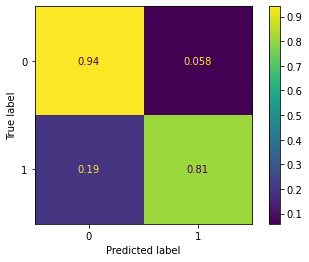

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y, preds, normalize='true', labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot() 
plt.show()

In [47]:
fpr, tpr, thresholds = roc_curve(y, train_preds)

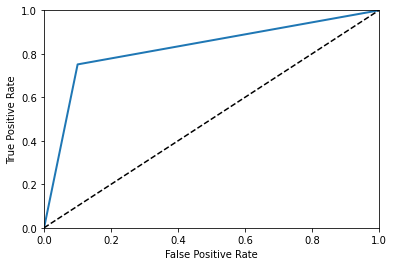

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

# Train on Full Data

In [49]:
full_model = get_model("XGBoost", params=params)
full_model.fit(X_prep, y)

X_test = test_data
X_test["title"] = X_test.Name.map(get_title)
X_test["FamilySize"] = X_test.Parch + X_test.SibSp
X_test["Age_class"] = X_test["Age"] // 15 * 15
X_test["Alone"] = X_test.FamilySize.map(lambda x: 1 if x == 0 else 0)
X_test = X_test[cols]

## Test Predictions

In [50]:
X_test_prep = data_prep_pipe.transform(X_test)
test_preds = full_model.predict(X_test_prep)

## Submission

In [51]:
# Saving the output for submission
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived':test_preds})
output.to_csv('my_submission.csv', index=False)